In [1]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import hdbscan
import seaborn as sns
sns.set_style("dark")

/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#pd.set_option("display.max_rows",500)
#pd.set_option("display.max_columns",100)
pd.set_option('max_colwidth', 1000)

In [3]:
bachelors = pd.read_csv('data/scorecard_reduced_bachelors.csv')
bachelors.set_index('UNITID', inplace=True)
bachelors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2560 entries, 100654 to 47702003
Columns: 1729 entries, OPEID to year
dtypes: float64(1720), object(9)
memory usage: 33.8+ MB


Group variables by dev-category using the Data Dictionary.

In [4]:
df_dict = pd.read_csv('data/CollegeScorecardDataDictionary-09-08-2015.csv')
df_dict.columns

Index(['NAME OF DATA ELEMENT', 'dev-category', 'developer-friendly name',
       'API data type', 'VARIABLE NAME', 'VALUE', 'LABEL', 'SOURCE', 'NOTES'],
      dtype='object')

In [5]:
df_dict.set_index('VARIABLE NAME', inplace=True)
dcat = df_dict.groupby('dev-category')
dcat.groups.keys()

dict_keys(['student', 'repayment', 'completion', 'root', 'aid', 'cost', 'admissions', 'earnings', 'academics', 'school'])

In [6]:
ac_vars = dcat.groups['academics']
ac_dict = dcat.get_group('academics')
len(ac_dict)

228

### The data in the _academics_ category consists of two things:  Percentage of degrees awarded in a particular discipline area, and flags for whether or not an institution has a given degree:

In [7]:
ac_dict[['developer-friendly name', 'NAME OF DATA ELEMENT']]

,developer-friendly name,NAME OF DATA ELEMENT
VARIABLE NAME,,
PCIP01,program_percentage.agriculture,"Percentage of degrees awarded in Agriculture, Agriculture Operations, And Related Sciences."
PCIP03,program_percentage.resources,Percentage of degrees awarded in Natural Resources And Conservation.
PCIP04,program_percentage.architecture,Percentage of degrees awarded in Architecture And Related Services.
PCIP05,program_percentage.ethnic_cultural_gender,"Percentage of degrees awarded in Area, Ethnic, Cultural, Gender, And Group Studies."
PCIP09,program_percentage.communication,"Percentage of degrees awarded in Communication, Journalism, And Related Programs."
PCIP10,program_percentage.communications_technology,Percentage of degrees awarded in Communications Technologies/Technicians And Support Services.
PCIP11,program_percentage.computer,Percentage of degrees awarded in Computer And Information Sciences And Support Services.
PCIP12,program_percentage.personal_culinary,Percentage of degrees awarded in Personal And Culinary Services.
PCIP13,program_percentage.education,Percentage of degrees awarded in Education.


### Now let's examine what data is available:

In [8]:
academics = bachelors[["INSTNM", "sch_deg", "year"]+ac_vars]

In [9]:
academics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2560 entries, 100654 to 47702003
Columns: 231 entries, INSTNM to CIP54BACHL
dtypes: float64(230), object(1)
memory usage: 4.5+ MB


## Histogram by school:

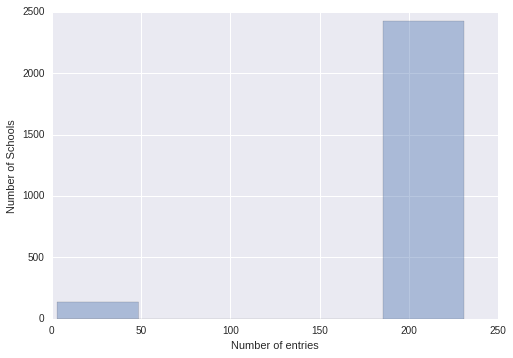

In [10]:
sns.set_style("darkgrid")
sns.distplot(academics.count(axis=1), bins=5, kde=False)
plt.xlabel("Number of entries")
plt.ylabel("Number of Schools")
plt.savefig("Academics_Data_histogram_all.png")

So, appears the majority of schools have nearly all the available data, while a few have nearly none.

### Histogram by Variable

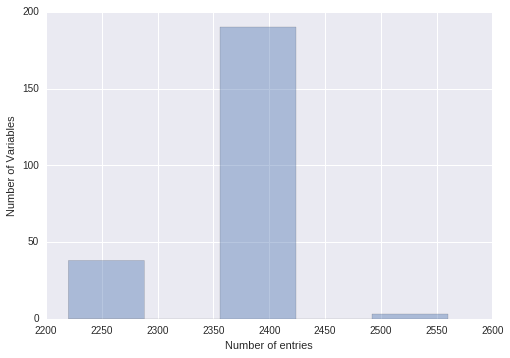

In [11]:
sns.distplot(academics.count(axis=0), bins=5, kde=False, rug=False)
plt.xlabel("Number of entries")
plt.ylabel("Number of Variables")

In [12]:
col_entry_counts = academics.count(axis=0)
col_entry_counts.sort_values()

col_entry_counts.unique()

array([2560, 2220, 2423])

In [13]:
col_entry_counts.unique()

array([2560, 2220, 2423])

Three.  Three unique counts for 231 entries.  Not a whole lot of variation here...

# Summary:
1. There is very little variation in the academic data once you combine all available years and take just the bachelor's degree-granting institutions.  
    * I did however note that sch_deg=3 does not restrict the data to your stereotypical 4-year public or private university, e.g., schools like the American Film Institute Conservatory, the Academy of Chinese Culture and Health Sciences, the Frank Lloyd Wright School of Architecture, and the American Baptist Seminary of the West.

2. There are 228 variables in the academics data, which can be broken into two categories:
    * Percentage of degrees awarded in a particular discipline area.
    * Flags for whether or not an institution has a given degree.

#### I suggest we drop all the degree flags and just keep the `PCIP[01-54]` variables for the percentage of degrees.  This information should be useful in distinguishing things like engineering schools, seminaries, and architecture schools from 4-year institutions with a broader mission.  

#### AND, if we want to further cut down the number of variables, we can combine these 54 variables further into broader degree classifications as needed.

In [14]:
from sklearn import preprocessing,decomposition

In [15]:
pcip_vars = ac_dict[~ac_dict.index.str.contains("CERT|ASSOC|BACH")].index
pcip = academics[pcip_vars].dropna(how='any')
pcip.columns

Index(['PCIP01', 'PCIP03', 'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10', 'PCIP11',
       'PCIP12', 'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16', 'PCIP19', 'PCIP22',
       'PCIP23', 'PCIP24', 'PCIP25', 'PCIP26', 'PCIP27', 'PCIP29', 'PCIP30',
       'PCIP31', 'PCIP38', 'PCIP39', 'PCIP40', 'PCIP41', 'PCIP42', 'PCIP43',
       'PCIP44', 'PCIP45', 'PCIP46', 'PCIP47', 'PCIP48', 'PCIP49', 'PCIP50',
       'PCIP51', 'PCIP52', 'PCIP54'],
      dtype='object')

In [16]:
programs = ac_dict.loc[pcip.columns]['developer-friendly name']
programs = programs.str.split('.',expand=True)[1]
program_dict = programs.to_dict()
pcip.rename(columns=program_dict, inplace=True)
pcip.columns

Index(['agriculture', 'resources', 'architecture', 'ethnic_cultural_gender',
       'communication', 'communications_technology', 'computer',
       'personal_culinary', 'education', 'engineering',
       'engineering_technology', 'language', 'family_consumer_science',
       'legal', 'english', 'humanities', 'library', 'biological',
       'mathematics', 'military', 'multidiscipline',
       'parks_recreation_fitness', 'philosophy_religious',
       'theology_religious_vocation', 'physical_science', 'science_technology',
       'psychology', 'security_law_enforcement',
       'public_administration_social_service', 'social_science',
       'construction', 'mechanic_repair_technology', 'precision_production',
       'transportation', 'visual_performing', 'health', 'business_marketing',
       'history'],
      dtype='object')

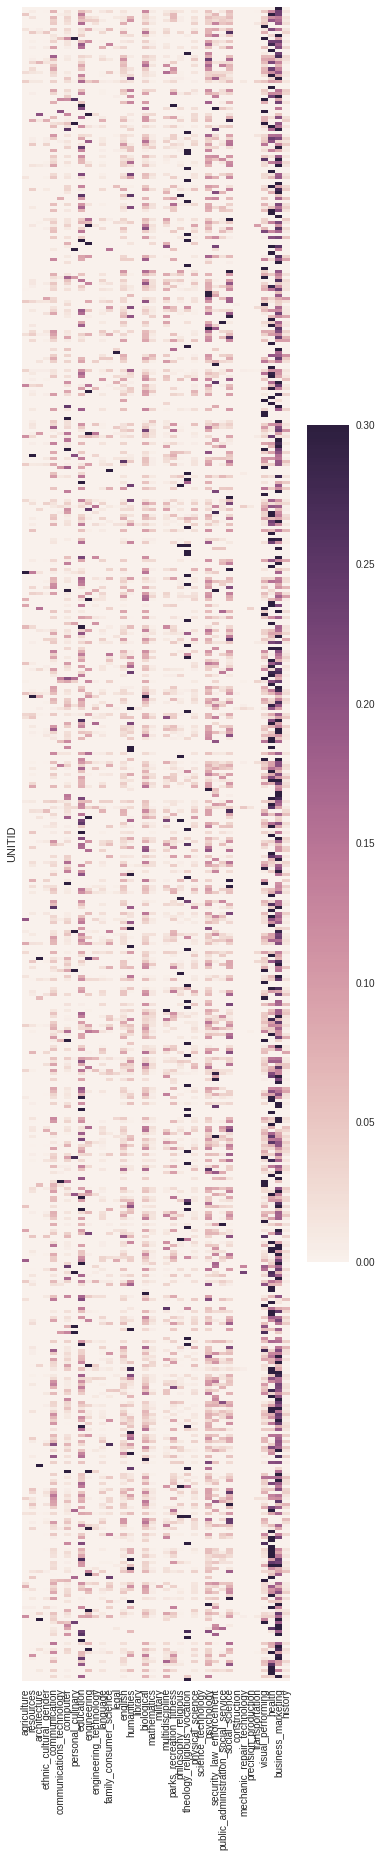

In [17]:
f,ax = plt.subplots(figsize=(6,30))
m = sns.heatmap(pcip.sample(frac=.25, axis=0), vmax=.3, vmin=0, square=False, yticklabels=False, cbar_kws={"shrink": .5})
#p = plt.setp(m.axes.xaxis.get_majorticklabels(), rotation=45)

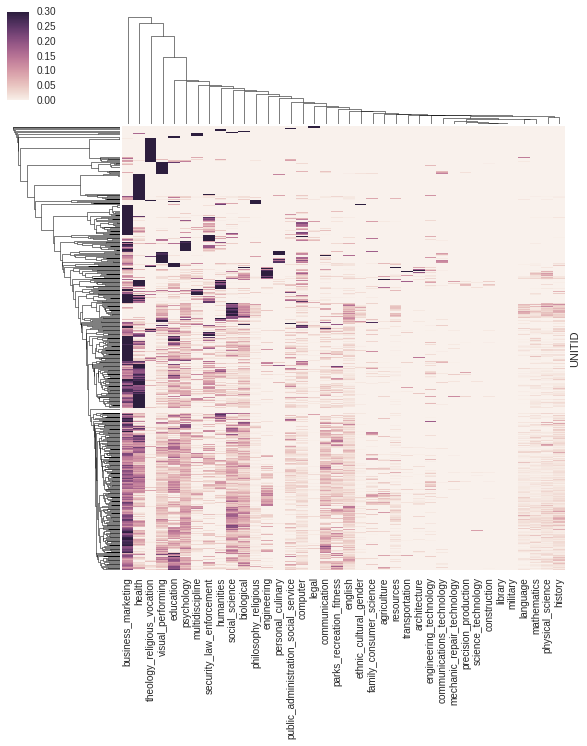

In [18]:
m = sns.clustermap(pcip.sample(frac=.25, axis=0), vmax=.3, vmin=0, square=False, yticklabels=False)
#p = plt.setp(m.axes.xaxis.get_majorticklabels(), rotation=45)

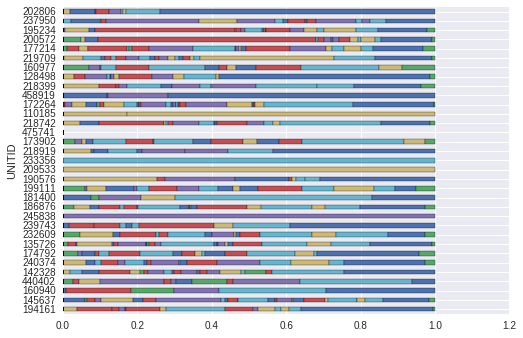

In [19]:
pcip.sample(frac=.015, axis=0).plot.barh(stacked=True, legend=False)

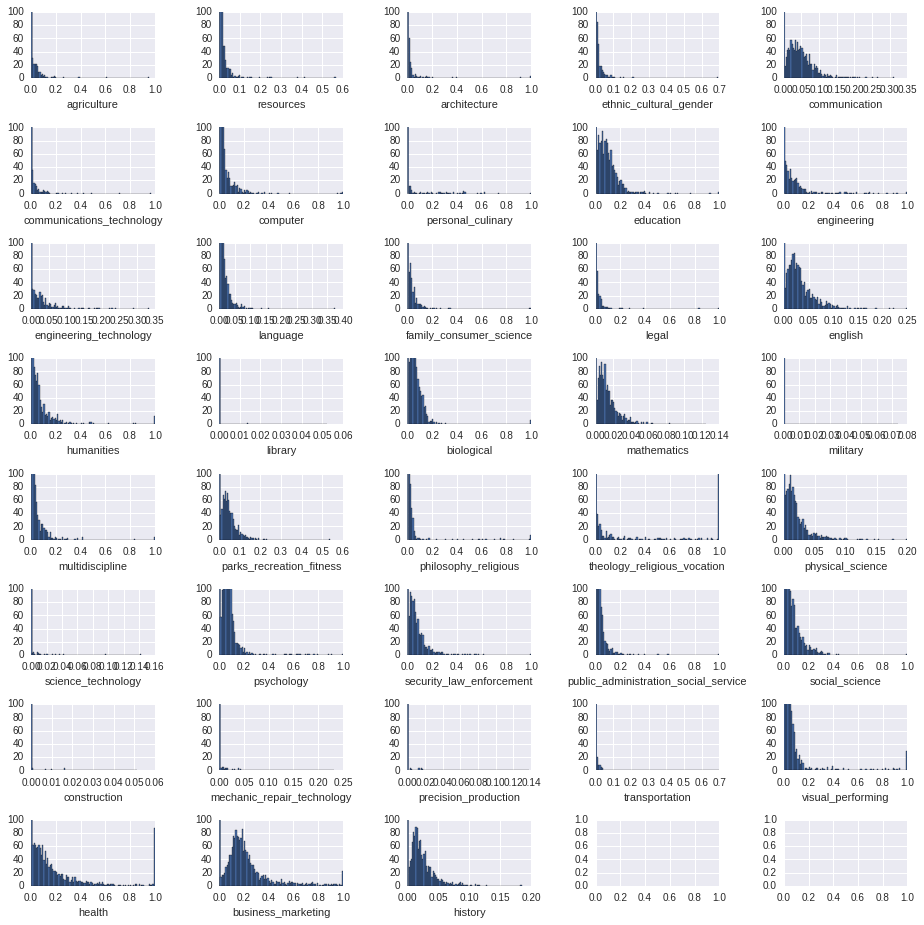

In [20]:
f,axarr = plt.subplots(8,5, figsize=(13,13))
axarr = axarr.flatten()
for i,field in enumerate(pcip.columns):
    pcip[field].hist(ax=axarr[i], bins=100)
    axarr[i].set_ylim(0,100)
    axarr[i].set_xlabel(field)
plt.tight_layout()

# Look at correlations:

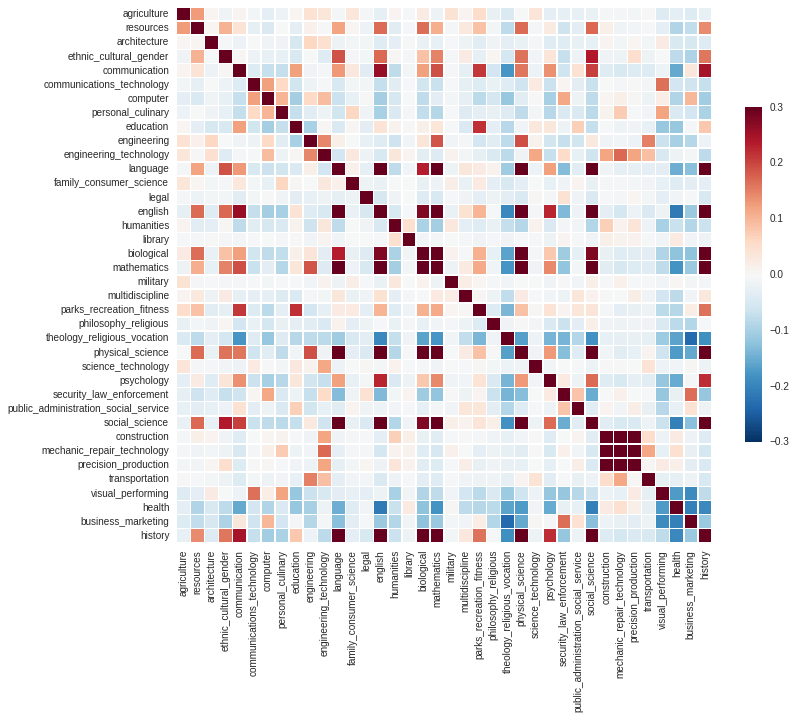

In [21]:
icorr = pcip.corr()
mask = np.zeros_like(icorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(12,12))
sns.heatmap(icorr, vmax=.3,square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5})

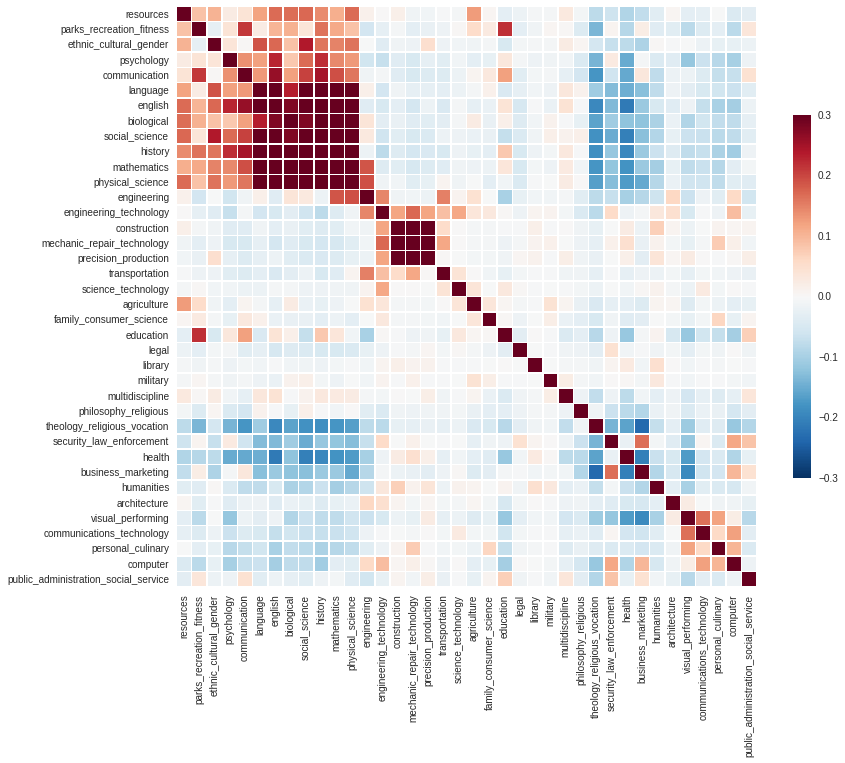

In [22]:
icorr_cols = ['resources', 
              'parks_recreation_fitness',
              'ethnic_cultural_gender', 
              'psychology',
              'communication', 
              'language',
              'english',
              'biological',
              'social_science',
              'history',
              'mathematics',
              'physical_science',
              'engineering',
              'engineering_technology',
              'construction',
              'mechanic_repair_technology',
              'precision_production',
              'transportation',
              'science_technology',
              'agriculture', 
              'family_consumer_science',
              'education',
              'legal',
              'library',
              'military',
              'multidiscipline',
              'philosophy_religious',
              'theology_religious_vocation',
              'security_law_enforcement',
              'health',
              'business_marketing',
              'humanities',
              'architecture', 
              'visual_performing',
              'communications_technology',
              'personal_culinary',
              'computer',
              'public_administration_social_service',
              ]

icorr_sorted = pcip[icorr_cols].corr()
f,ax = plt.subplots(figsize=(13,13))
sns.heatmap(icorr_sorted, vmax=.3,square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5})

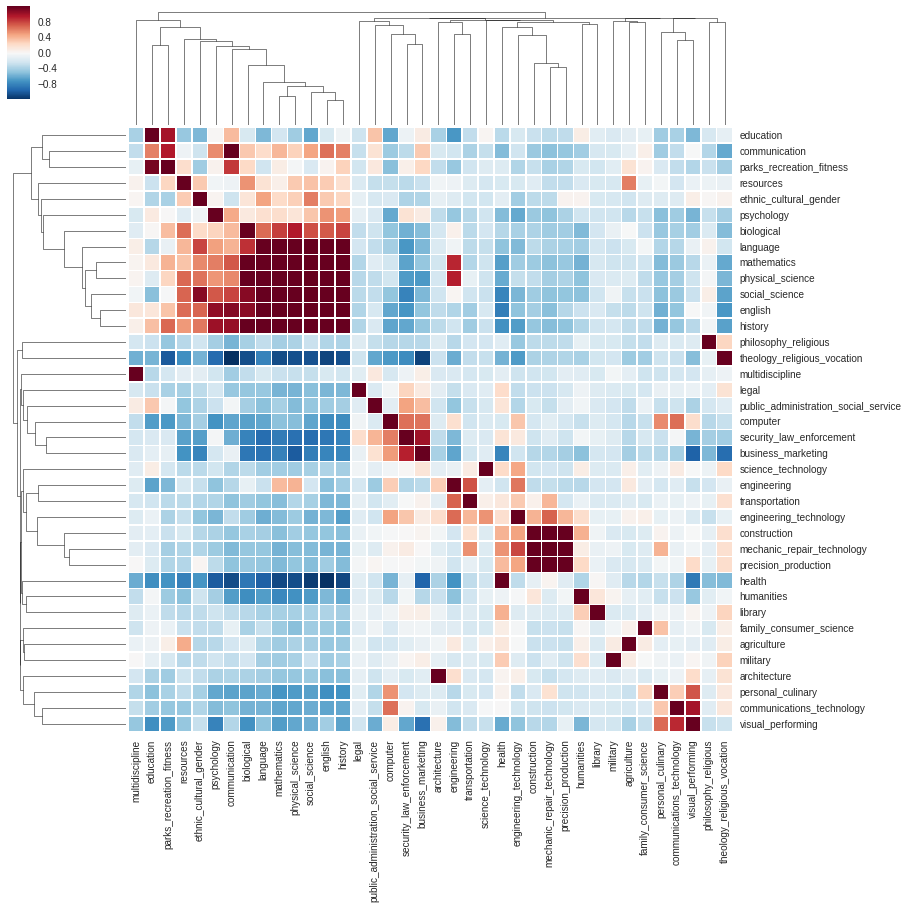

In [23]:
cg = sns.clustermap(pcip.corr(), vmax=.5,square=True, xticklabels=True, yticklabels=True,
                    linewidths=.5, figsize=(13, 13), z_score=1)
p = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

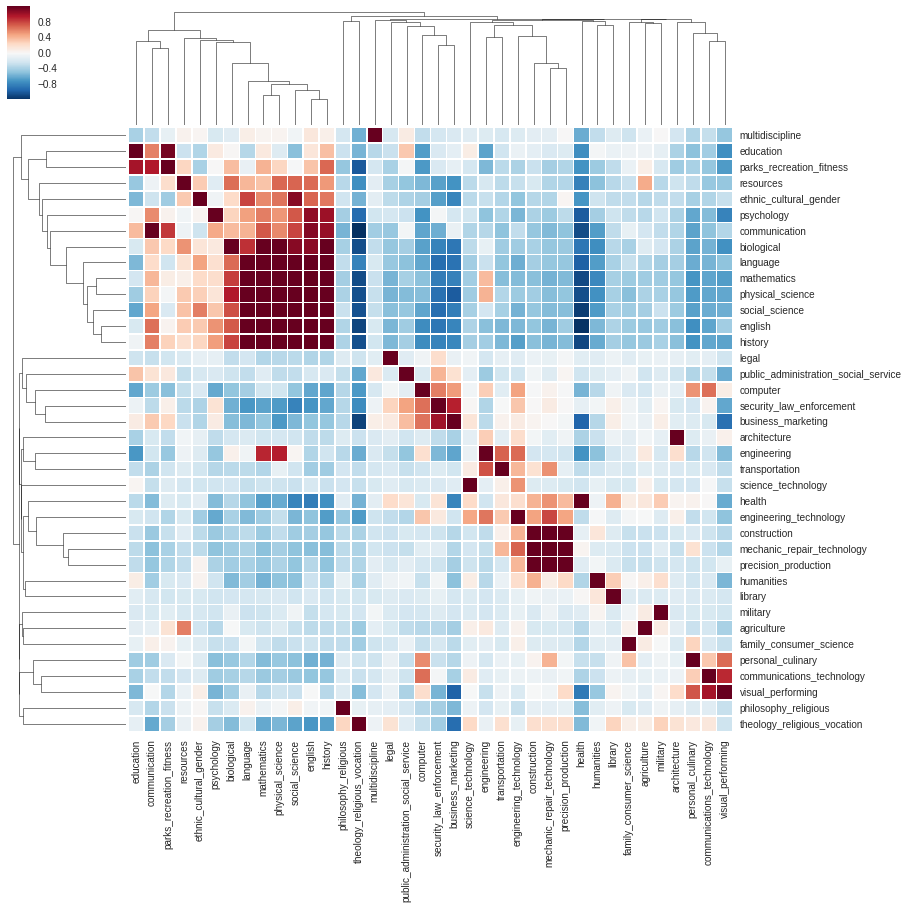

In [24]:
cg = sns.clustermap(pcip.corr(), vmax=.5,square=True, xticklabels=True, yticklabels=True,
                    linewidths=.5, figsize=(13, 13), z_score=0)
p = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

# Let's do a principal component analysis, and see if the components match up to the clusters above:

In [25]:
#pcip = preprocessing.normalize(pcip, axis=0)
pca = decomposition.PCA(n_components=4).fit(pcip)
print(pca.explained_variance_ratio_, "-- Fractional variance explained by each component.")
print(pca.explained_variance_ratio_.cumsum(),"-- Cummulative variance explained for Successive components")

[ 0.24424412  0.22082681  0.14742853  0.08840003] -- Fractional variance explained by each component.
[ 0.24424412  0.46507093  0.61249946  0.70089949] -- Cummulative variance explained for Successive components


In [26]:
components = pd.DataFrame(pca.components_.transpose(), index=programs.tolist(), 
                          columns=['Principal Component 1','Principal Component 2','Principal Component 3',
                                   'Principal Component 4'])

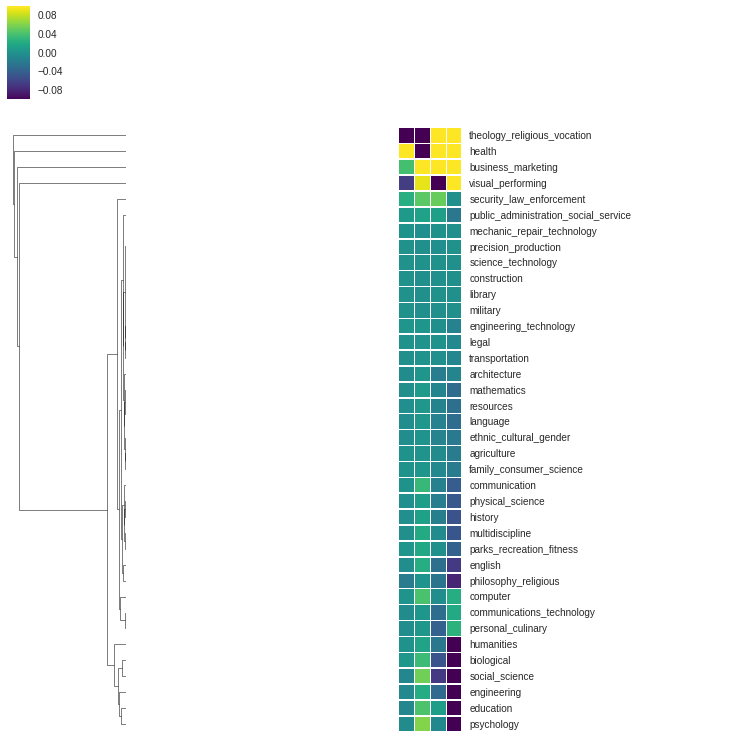

In [27]:
cg = sns.clustermap(components, cmap=plt.cm.viridis, vmax=.1, vmin=-.1, figsize=(13,13),
                    square=True, xticklabels=False, yticklabels=True, linewidths=.5, col_cluster=False)
p = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [28]:
components[np.abs(components) > .2].dropna(how='all')

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4
humanities,NaN,NaN,NaN,-0.262457
theology_religious_vocation,-0.687685,-0.583962,0.283112,0.234968
visual_performing,NaN,NaN,-0.704362,0.638601
health,0.721104,-0.579617,NaN,0.248890
business_marketing,NaN,0.543822,0.615424,0.496168


# Summary

After going through all that, we end up with basically the categories I would have naiively chosen by hand :-/

I suggest we sum the following columns to create 4 new features: percent of degrees awarded in **Liberal Arts**, **Vocational**, **Professional**, and **Religious**.
#### Liberal arts:
- `PCIP01`: agriculture
- `PCIP03`: resources
- `PCIP05`: ethnic_cultural_gender
- `PCIP09`: communication
- `PCIP13`: education
- `PCIP16`: language
- `PCIP23`: english
- `PCIP24`: humanities
- `PCIP26`: biological
- `PCIP27`: mathematics
- `PCIP30`: multidiscipline
- `PCIP31`: parks_recreation_fitness
- `PCIP40`: physical_science
- `PCIP42`: psychology
- `PCIP45`: social_science
- `PCIP54`: history

#### Vocational:
- `PCIP15`: engineering_technology
- `PCIP19`: family_consumer_science
- `PCIP41`: science_technology
- `PCIP46`: construction
- `PCIP47`: mechanic_repair_technology
- `PCIP48`: precision_production
- `PCIP49`: transportation

#### Professional:
- `PCIP04`: architecture
- `PCIP10`: communications_technology
- `PCIP11`: computer
- `PCIP12`: personal_culinary
- `PCIP14`: engineering
- `PCIP22`: legal
- `PCIP25`: library
- `PCIP29`: military
- `PCIP43`: security_law_enforcement
- `PCIP44`: public_administration_social_service
- `PCIP43`: security_law_enforcement
- `PCIP50`: visual_performing
- `PCIP51`: health
- `PCIP52`: business_marketing

#### Professional:
- `PCIP38`: philosophy_religious
- `PCIP39`: theology_religious_vocation
   